In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from datasets import *
from models import *
from transforms import *

Available workers: 16


In [3]:
def show_dataset_cleaning_scores(dsname="Suzukii_RL/Y", bs=32, clean=False):
    d = WingbeatsDataset(dsname=dsname, custom_label=[1], clean=clean, transform=transforms.Compose([Bandpass(), NormalizedPSDSums(norm='l2')]))
    dloader = DataLoader(d, batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)
    sums = []
    for s,_,_,_,_ in tqdm(dloader, total=len(d)//bs):
        sums.extend(s)
    sums = pd.DataFrame(torch.tensor(sums), columns=['sums'])
    plt.ylim(0,900)
    plt.xlim(5,45)
    np_hist(sums, 'sums', res=0.1)

# Suzukii cleaning scores

In [6]:
show_dataset_cleaning_scores(dsname="Suzukii_RL/Y")

  0%|          | 0/804 [00:00<?, ?it/s]

Found 25732 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


 17%|█▋        | 138/804 [00:19<01:35,  6.99it/s]


KeyboardInterrupt: 

Cleaning dataset Suzukii_RL/Y..	:   0%|          | 0/858 [00:00<?, ?it/s]

Found 25732 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']


  0%|          | 0/599 [00:00<?, ?it/s]

Found 19183 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


600it [00:46, 12.97it/s]                         


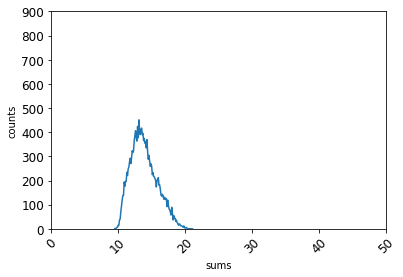

In [6]:
show_dataset_cleaning_scores(dsname="Suzukii_RL/Y", clean=True)

  0%|          | 0/614 [00:00<?, ?it/s]

Found 19657 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


615it [01:02,  9.80it/s]                         


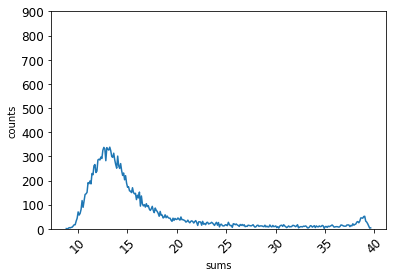

In [12]:
show_dataset_cleaning_scores(dsname="Suzukii_RL/X")

# Melanogaster cleaning scores

  0%|          | 0/906 [00:00<?, ?it/s]

Found 29002 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [1]


907it [01:05, 13.80it/s]                         


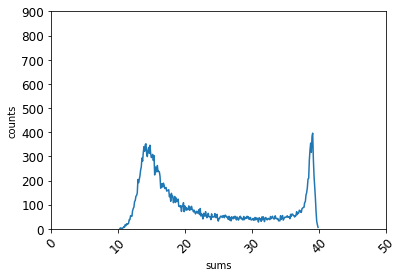

In [7]:
show_dataset_cleaning_scores(dsname="Melanogaster_RL/Y")

Cleaning dataset Melanogaster_RL/Y..	:   0%|          | 0/967 [00:00<?, ?it/s]

Found 29002 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']


  0%|          | 0/430 [00:00<?, ?it/s]

Found 13781 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [1]


431it [00:31, 13.64it/s]                         


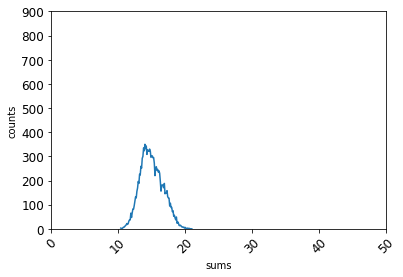

In [8]:
show_dataset_cleaning_scores(dsname="Melanogaster_RL/Y", clean=True)

  0%|          | 0/773 [00:00<?, ?it/s]

Found 24763 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [1]


774it [01:11, 10.76it/s]                         


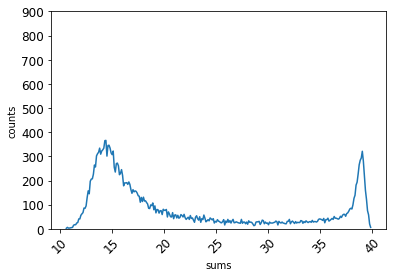

In [14]:
show_dataset_cleaning_scores(dsname="Melanogaster_RL/Z")

In [23]:
# stft = WingbeatsDataset(dsname="Melanogaster_RL/X", custom_label=[1], clean=True, transform=transforms.Compose([Bandpass(), TransformWingbeat(setting='stft')]));
# plt.imshow(stft[13][0][0]);

# Plotting raw signals

In [38]:
d = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[1], clean=False, transform=transforms.Compose([Bandpass()]))
dloader = DataLoader(d, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
signals = []
for s,_,_,_ in tqdm(dloader, total=len(d)//64):
    signals.extend(s)
signals = pd.DataFrame(np.stack(signals).squeeze())

  0%|          | 0/386 [00:00<?, ?it/s]

Found 24763 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [1]


387it [00:03, 122.49it/s]                         


In [57]:
dirty = signals.loc[sums[sums.sums>22].index]
clean = signals.loc[sums[sums.sums<22].index]

a = dirty.sample(20)
b = clean.sample(20)

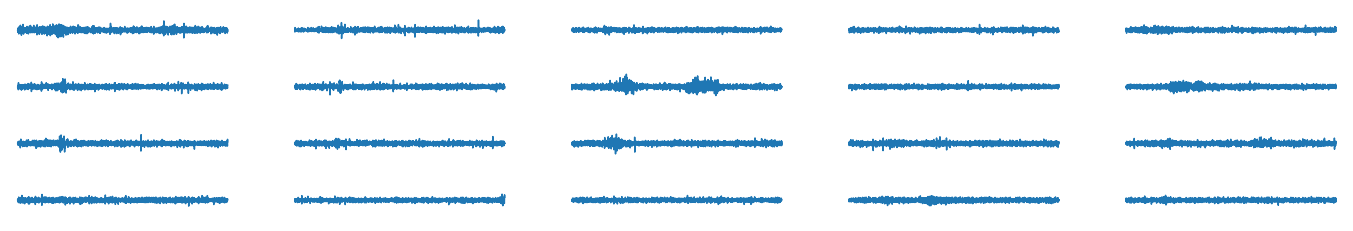

In [58]:
plt.figure(figsize=(24,4))
for i in range(20):
    plt.subplot(4,5,i+1)
    sig = a.iloc[i]
    plt.plot(sig)
    plt.axis('off')
    plt.ylim(-.05,.05)

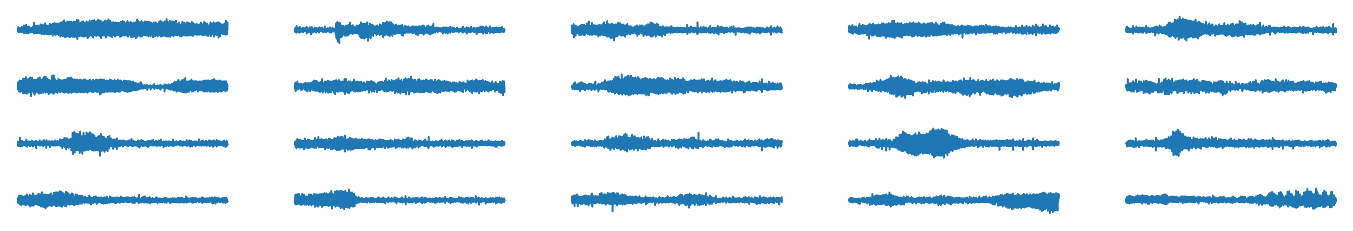

In [59]:
plt.figure(figsize=(24,4))
for i in range(20):
    plt.subplot(4,5,i+1)
    sig = b.iloc[i]
    plt.plot(sig)
    plt.axis('off')
    plt.ylim(-.05,.05)